In [23]:
%load_ext autoreload
%autoreload 2
%run basic_material

import random, sys, copy
from numpy.random import randn
import scipy.linalg
from scipy.linalg import expm, sqrtm

import scipy.optimize
import sympy as sym
from scipy.optimize import minimize

from sympy import Matrix, init_printing
init_printing()

import pandas as pd 

plt.rcParams['axes.grid'] = True
plt.style.use('fivethirtyeight') # For better style
plt.rcParams["figure.figsize"] = (8,5)

d2r = np.pi/180
Low_Noise = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running Python: 3.8.16


In [47]:
# Now look for the optimal solution
# form cost on 10-2 and optimize it
def func_NLS(xh, Q0, x0, z, L, V):
    xt = xh.reshape(2, 1) - x0
    J1 = xt.T@np.linalg.inv(Q0)@xt
    if (np.size(z) < 2):
        zt = z - np.matrix([Measurement(xh.reshape(2, 1),L)])
    else:
        zt = z - np.matrix([Measurement(xh.reshape(2, 1),L[0]), Measurement(xh.reshape(2, 1),L[1])]).T
    J2 = np.dot(zt.T,zt)/V
    return J1.item() + J2.item()

In [48]:
#actual (unknown) solution
x = np.array([[-3], [0]])

# initial uncertainty in location
Q0 = np.matrix([[0.2**2, 0], [0, 0.3**2]]) # initial state uncertainty

# initially start at xb within +/-1sigma of the actual 
xb = x + sqrtm(Q0)@np.vstack(randn(2)) # initial state used in the opt
xb = np.vstack(np.array([[-3.3], [0.2]])) # interesting problem to solve

if 0:
    L = 4 # +ve taken to be in the negative x_2 direction
    L2 = -2 # location of second measurement
else: # reverse order of meas
    L = -2 
    L2 = 4 
    
TOL = 1e-11 # solution tolerance
rr_max = 12 # max number of iterations

V = (0.7*d2r)**2 # measurement noise
   
# define geometry of problem and 
# measurements, which are the angles between the 2 beacons 
x1,x2,sL = sym.symbols('x1 x2 sL')
r1sq = x1**2 + x2**2
r2sq = x1**2+(x2+sL)**2
fun = sym.acos((sL**2-r1sq-r2sq)/(-2*sym.sqrt(r1sq*r2sq)))
numfun=sym.lambdify([x1,x2,sL],fun) # measurement equation
gradfun=[sym.diff(fun,var) for var in (x1,x2)] #take the gradient symbolically wrt x
numgradfun=sym.lambdify([x1,x2,sL],gradfun) #turn into a bivariate lambda for numpy

def Measurement(xm,L):
    return numfun(xm[0,0],xm[1,0],L)

# Actual measurements
z_act_1 = Measurement(x,L) # beacons 0 and 1
z_act_2 = Measurement(x,L2) # beacons 0 and 2

# add random noise scaled by V
z =  z_act_1 + np.sqrt(V)*randn(1) # measured angle (note the sqrt here)
z3 = z_act_2 + np.sqrt(V)*randn(1) # second measured angle (note the sqrt here)

print(f'Actual state x: ',x.T[0])
print(f'Initial belief: ',xb.T[0])
print('\nActual First Alpha: ' + str(round(z_act_1/d2r,2)),'degs')
print('Meas First Alpha: ' + str(round(z[0]/d2r,2)), 'degs')
print('\nActual Second Alpha: ' + str(round(z_act_2/d2r,2)),'degs')
print('Meas Second Alpha: ' + str(round(z3[0]/d2r,2)), 'degs')

Actual state x:  [-3  0]
Initial belief:  [-3.3000  0.2000]

Actual First Alpha: 33.69 degs
Meas First Alpha: 33.87 degs

Actual Second Alpha: 53.13 degs
Meas Second Alpha: 52.27 degs


In [49]:
# optimized results
# callback storage
all_x_i=[]
all_y_i=[]
all_x_i.append(xb[0][0])
all_y_i.append(xb[1][0])
def store(x):
    all_x_i.append(x[0])
    all_y_i.append(x[1])

In [50]:
def nllsfit(x0,Q0,xk,Qk,z,R,L):  # see 12-4 for equations
    zk = Measurement(xk,L) # measurement would get at current estimate xk 
    H = np.asmatrix(numgradfun(xk[0,0],xk[1,0],L)) # linearized meas matrix
    Qkp1 = np.linalg.inv(np.linalg.inv(Q0) + H.T@np.linalg.inv(np.atleast_2d(R))@H) 
    xkp1 = x0 + Qkp1@H.T*(z - zk - H@(x0 - xk))/R
    zkp1 = Measurement(xkp1,L) # measurement would get at current estimate xk 
    GR = np.linalg.inv(Q0)@(xkp1 - x0) - H.T*(z - zkp1)/R
    return  xkp1, Qkp1, GR

def iterated_solution(x0,Q0,z,V,L):
    # iterated solution
    xh = copy.deepcopy(x0) # temporary solution
    Qh = copy.deepcopy(Q0) # temporary solution
    GR = 1 
    iter_count = 0 #limit on the # of iterations
    X = np.zeros((rr_max+1,3))   # storage
    while ((np.linalg.norm(GR) > TOL) & (iter_count < rr_max)):
        X[iter_count][0:2] = xh.T  
        X[iter_count][2] = iter_count
        xh,Qh,GR = nllsfit(x0,Q0,xh,Qh,z,V,L)
        iter_count += 1
    else:
        X[iter_count][0:2] = x.T  # put actual answer as last value for plotting reasons
        X[iter_count][2] = iter_count
    return np.asarray(xh).flatten(), np.asarray(Qh),  iter_count, X[0:iter_count,:]

In [51]:
def solve_both(xb,Q0,z,V,L):
    xh, Qh, iter_number, X = iterated_solution(xb,Q0,z,V,L)

    kk = minimize(func_NLS, xb[:,0].T, args=(Q0, xb, z, L, V), callback=store)
    BFGS_sol_path = np.array([all_x_i,all_y_i])

    print("Initial", xb.flatten())

    print("Optimized")
    table_opt = []
    table_opt.append(all_x_i)
    table_opt.append(all_y_i)
    df_opt = pd.DataFrame(table_opt, index=['X1', 'X2'])
    df_opt[df_opt.isna()]=0
    print(df_opt.T)

    print("\nIterated")
    table_iterated = []
    table_iterated.append(X[:,0])
    table_iterated.append(X[:,1])
    df_iterated = pd.DataFrame(table_iterated, index=['X1', 'X2'])
    df_iterated[df_iterated.isna()]=0
    print(df_iterated.T)


    fig, ax = plt.subplots()
    ax.plot(all_x_i, all_y_i,'r',label="Optimal")
    ax.plot(X[:,0], X[:,1],'b',label="Iterated")
    ax.plot(all_x_i, all_y_i,'ro')
    ax.plot(X[0,0], X[0,1],'ks')
    ax.plot(X[:,0], X[:,1],'bo')
    ax.plot(x[0], x[1],'gs')
    ax.set_title('Single Optimization Step')
    plt.legend()
    plt.savefig('filename.png',dpi=600, format="png",transparent=True)
    plt.show()

Initial [-3.3000  0.2000]
Optimized
         X1        X2
0 -3.300000  0.200000
1 -3.161949  0.264792
2 -3.178265  0.302790
3 -3.170769  0.311700
4 -3.168285  0.319597
5 -3.168586  0.320302
6 -3.168613  0.320365

Iterated
         X1        X2
0 -3.300000  0.200000
1 -3.171326  0.335880
2 -3.167803  0.318018
3 -3.168747  0.320721
4 -3.168592  0.320310
5 -3.168616  0.320373
6 -3.168612  0.320364
7 -3.168613  0.320365


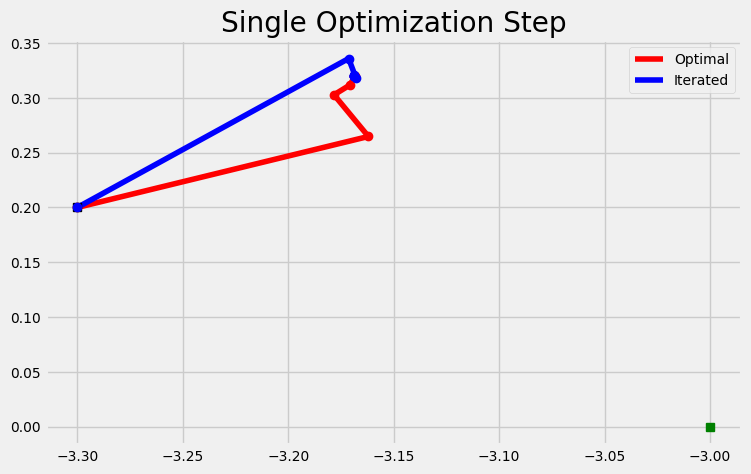

In [52]:
solve_both(xb,Q0,z,V,L)

Initial [-3.3000  0.2000]
Optimized
          X1        X2
0  -3.300000  0.200000
1  -3.161949  0.264792
2  -3.178265  0.302790
3  -3.170769  0.311700
4  -3.168285  0.319597
5  -3.168586  0.320302
6  -3.168613  0.320365
7  -3.158529 -0.004394
8  -3.182182 -0.021762
9  -3.184081 -0.040598
10 -3.192425 -0.066454
11 -3.196826 -0.070508
12 -3.197425 -0.071059
13 -3.197426 -0.071061

Iterated
         X1        X2
0 -3.300000  0.200000
1 -3.210908 -0.089614
2 -3.195916 -0.069510
3 -3.197565 -0.071187
4 -3.197414 -0.071050
5 -3.197427 -0.071062
6 -3.197426 -0.071061


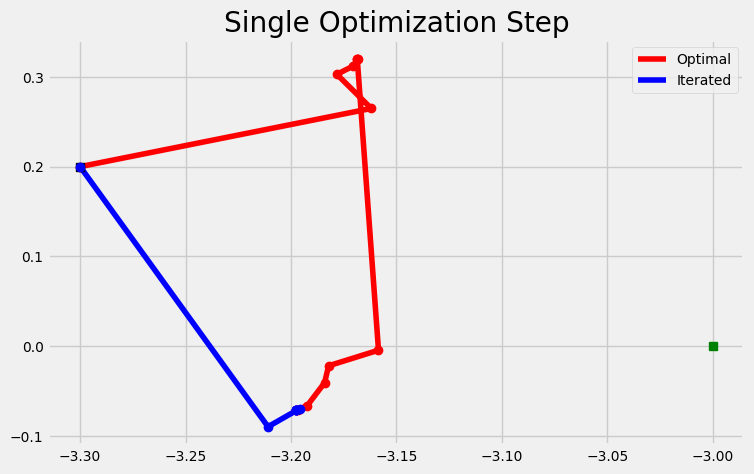

In [53]:
solve_both(xb,Q0,z3,V,L2)